In [1]:
# Initial imports
from path import Path
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
%matplotlib inline

In [2]:
# import CSV file into dataframe

file_path = Path('Resources/financials_and_sentiments.csv')
df = pd.read_csv(file_path)
#df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
#df.set_index('Date',inplace=True)
#df.sort_index(inplace=True)
df.dropna()


,Ticker,Date,Pos,Neu,Neg,Normalized,Close,Returns,12-day Rolling,5-day Rolling,3-day Rolling,12-day Rolling Std,5-day Rolling Std,3-day Rolling Std,difference 1-day,difference 3-days,direction 1-day,direction 3-days
0,A,2019-08-14,0.101,0.884,0.014,1,65.59,-0.030308,-0.005657,-0.006860,-0.014811,0.020223,0.024598,0.025959,-2.05,-3.05,0,0
1,AAL,2019-10-24,0.133,0.847,0.020,1,29.41,0.039590,0.009595,0.010526,0.009358,0.015567,0.019245,0.027056,1.12,0.79,1,1
2,AAP,2019-11-12,0.121,0.863,0.015,1,156.14,-0.075110,-0.004594,-0.014186,-0.025911,0.024032,0.035081,0.043719,-12.68,-13.14,0,0
3,AAPL,2019-10-30,0.130,0.851,0.018,1,243.26,-0.000123,0.002627,0.000145,-0.004411,0.010672,0.014049,0.016983,-0.03,-3.32,0,0
4,ABBV,2019-11-01,0.118,0.862,0.020,1,81.75,0.027656,0.007551,0.013349,0.013813,0.011847,0.012865,0.014565,2.20,3.28,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,XRX,2019-10-29,0.135,0.837,0.028,1,34.42,0.117895,0.013695,0.026423,0.043784,0.034155,0.051763,0.064229,3.63,4.04,1,1
431,XYL,2019-08-01,0.148,0.834,0.018,1,78.81,-0.018433,-0.003877,-0.007078,-0.008607,0.010451,0.008061,0.010731,-1.48,-2.08,0,0
432,YUM,2019-10-30,0.157,0.827,0.016,1,103.34,-0.058148,-0.007123,-0.010805,-0.017491,0.018669,0.026579,0.035222,-6.38,-5.76,0,0
433,ZION,2019-10-21,0.126,0.845,0.029,1,45.67,0.021243,0.005741,0.006877,0.007600,0.014913,0.014507,0.018830,0.95,1.01,1,1


In [3]:
df['month'] = pd.DatetimeIndex(df['Date']).month
columns_to_drop = ["Ticker","Date","Normalized","Close","Returns",
                   "5-day Rolling","3-day Rolling","5-day Rolling Std","3-day Rolling Std",
                   "difference 1-day","difference 3-days","direction 3-days"]
df_12day_post1day = df.drop(columns=columns_to_drop)
df_12day_post1day.dropna(inplace=True)
df_12day_post1day.head()

,Pos,Neu,Neg,12-day Rolling,12-day Rolling Std,direction 1-day,month
0,0.101,0.884,0.014,-0.005657,0.020223,0,8
1,0.133,0.847,0.020,0.009595,0.015567,1,10
2,0.121,0.863,0.015,-0.004594,0.024032,0,11
3,0.130,0.851,0.018,0.002627,0.010672,0,10
4,0.118,0.862,0.020,0.007551,0.011847,1,11


# Split and Train Model

In [4]:
# Create our features
X = df_12day_post1day.drop(columns=["direction 1-day"]).values

# Create our target
y = df_12day_post1day["direction 1-day"].values

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y,test_size=.3)

X_val,X_test,y_val,y_test=train_test_split(X_val_and_test, y_val_and_test,test_size=.5)


In [5]:
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)

# Define the model - shallow neural net
number_hidden_nodes =70
number_input_features = 6

nn = Sequential([
    
    Dense(units=number_hidden_nodes, input_dim=number_input_features, activation=tf.nn.relu),
    Dense(units=1, activation="linear")
])
# Compile the model
nn.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanSquaredError()])

# Train the model
model_1 = nn.fit(X_train_scaled, y_train, epochs=300,validation_data=(X_val, y_val),verbose=0)


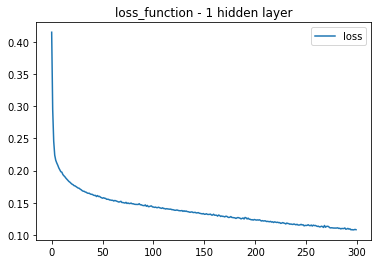

In [6]:
# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 1 hidden layer")
plt.legend(["loss"])
plt.show()

In [7]:
# Define the model - deep neural net
number_input_features = 6
hidden_nodes_layer1 =32
hidden_nodes_layer2 = 70

nn1 = Sequential([
    Dense(units=hidden_nodes_layer2, input_dim=number_input_features, activation=tf.nn.relu),
    Dense(units=hidden_nodes_layer2, activation=tf.nn.relu),
    Dense(units=hidden_nodes_layer2, activation=tf.nn.relu),
   
     #Dense(units=18, activation=tf.nn.relu),
    Dense(units=1, activation="linear")
])

In [8]:
# Compile model
#nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
nn1.compile(loss=tf.losses.mean_squared_error, optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanSquaredError()])
# Fit the model
model_2 = nn1.fit(X_train_scaled, y_train, epochs=300,validation_data=(X_val, y_val) ,verbose=0)


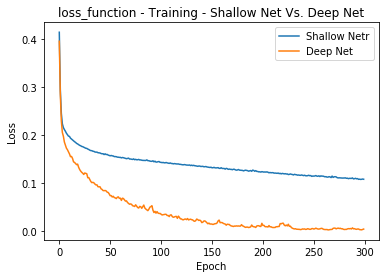

In [9]:
plt.plot(model_1.history["loss"])
plt.plot(model_2.history["loss"])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("loss_function - Training - Shallow Net Vs. Deep Net")
plt.legend(["Shallow Netr", "Deep Net"])
plt.show()

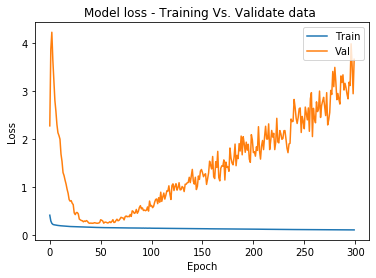

In [10]:
# Train vs test for shallow net
#plt.plot(model_1.history["loss"])
#plt.plot(model_1.history["val_loss"])
#plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
#plt.legend(["train", "test"])
#plt.show()
plt.plot(model_1.history['loss'])
plt.plot(model_1.history['val_loss'])
plt.title('Model loss - Training Vs. Validate data ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

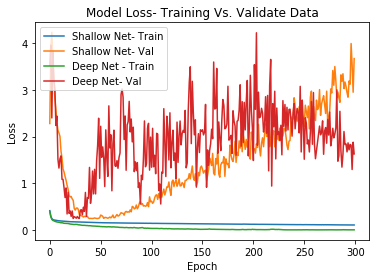

In [11]:
# Train vs test for deep net
plt.plot(model_1.history['loss'])
plt.plot(model_1.history['val_loss'])
plt.plot(model_2.history["loss"])
plt.plot(model_2.history["val_loss"])
plt.title("Model Loss- Training Vs. Validate Data")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Shallow Net- Train", "Shallow Net- Val",'Deep Net - Train','Deep Net- Val'])
plt.show()

In [12]:
# Evaluate the model using linear testing data
model_loss, model_accuracy = nn.evaluate(
    X_test_scaled, y_test, verbose=2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

66/1 - 0s - loss: 0.1127 - mean_squared_error: 0.2026
Loss: 0.202624421228062, Accuracy: 0.20262442529201508


In [13]:
model_loss, model_accuracy = nn1.evaluate(
    X_test_scaled, y_test, verbose=2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

66/1 - 0s - loss: 0.2700 - mean_squared_error: 0.4668
Loss: 0.46678735315799713, Accuracy: 0.4667873680591583


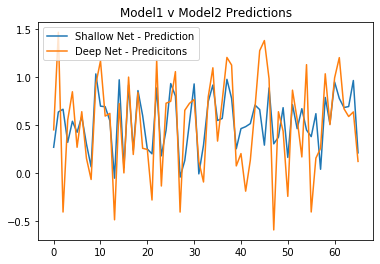

In [14]:
predicted_value_1 = nn.predict(X_test_scaled)
predicted_value_2 = nn1.predict(X_test_scaled)
plt.plot(predicted_value_1)
plt.plot(predicted_value_2)
plt.title("Model1 v Model2 Predictions")
plt.legend(["Shallow Net - Prediction", "Deep Net - Predicitons"])
plt.show()